<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Классификация комментариев на позитивные и негативные

## Подготовка

In [19]:
import pandas as pd #импортируем библиотеку pandas
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt #импортируем библиотеку plt
import re #импортируем библиотеку re
import time #импортируем библиотеку time
import warnings #импортируем библиотеку warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression #импортируем библиотеку LogisticRegression
from sklearn.tree import DecisionTreeClassifier #импортируем библиотеку DecisionTreeClassifier
from lightgbm import LGBMClassifier #импортируем библиотеку LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer #импортируем библиотеку TfidfVectorizer
from sklearn.model_selection import train_test_split #импортируем функцию train_test_split
from sklearn.metrics import f1_score #импортируем функцию f1_score
from sklearn.metrics import confusion_matrix #импортируем функцию confusion_matrix

import nltk #импортируем библиотеку nltk
from nltk.corpus import stopwords #импортируем stopwords
from nltk.tokenize import word_tokenize #импортируем word_tokenize
from nltk.stem import WordNetLemmatizer  #импортируем библиотеку WordNetLemmatizer
nltk.download('stopwords') #загрузим stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
data = pd.read_csv('/datasets/toxic_comments.csv') #считаем файл с данными и сохраним в data

In [21]:
data.info() #получим общую информацию о данных в таблице data
data.head(10)  #выведем первые 10 строк таблицы data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [22]:
display(data['text'])

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: text, Length: 159571, dtype: object

В столбце 'text' видим, что есть слова, начинающиеся с верхнего регистра. Также содержатся знаки препинания и нет приведения слов к начальной форме.

Для того, чтобы обучить модели классифицировать текст на позитивные и негативные комментарии, нужно устранить эти проблемы.

###### Лемматизация

Напишем функцию лемматизации текста.

In [23]:
def lemmatize_text(text):
    text = text.lower() # приведем к нижнему регистру
    clear = re.sub(r'[^a-zA-Z]', ' ', text) # очистим от лишних символов
    words = word_tokenize(clear) #разобъем предложение на слова 
    lemmatized_output = ' '.join([lemmatizer.lemmatize(word) for word in words]) # лемматизируем
    return lemmatized_output

Создадим класс для лемматизации.

In [24]:
lemmatizer = WordNetLemmatizer()

Применим функцию lemmatize_text к столбцу 'text' таблицы data.

In [25]:
data['text'] = data['text'].apply(lemmatize_text) #методом apply применим функцию к data['text']

In [26]:
data

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestion on impro...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159566,and for the second time of asking when your vi...,0
159567,you should be ashamed of yourself that is a ho...,0
159568,spitzer umm there no actual article for prosti...,0
159569,and it look like it wa actually you who put on...,0


## Обучение

Выделим признаки.

In [27]:
features = data.drop(['toxic'], axis=1) #выделим признаки
target = data['toxic'] #выделим целевой признак toxic

Разделим данные на обучающую и тестовую выборки.

In [28]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345) # функцией train_test_split разделим на обучающую и тестовую выборки

Сперва установим стоп-слова и создадим счетчик TfidfVectorizer.

In [29]:
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) #создадим счётчик, указав в нём стоп-слова

Затем создадим корпус текстов отдельно для обучающей и тестовой выборок. Преобразуем столбец 'text' в список текстов. Переведём тексты в стандартный для Python формат: кодировку Unicode U. Изменим кодировку методом astype().

Передадим счётчику корпус текстов. Для этого вызовем функцию fit_transform() для обучающей и transform() для тестовой. Счётчик выделит из корпуса уникальные слова и посчитает количество их вхождений в каждом тексте корпуса.

In [30]:
features_train = count_tf_idf.fit_transform(features_train['text']) #для корпуса текстов, вызовем функцию fit_transform():
features_test = count_tf_idf.transform(features_test['text'])

In [31]:
features_train.shape, features_test.shape

((95742, 117249), (63829, 117249))

Напишем функцию для расчета времени выполнения обучения модели.

In [32]:
def getTimeModel(model):
    start = time.time() #получим текущее время и запишем в переменную start
    model.fit(features_train, target_train) #обучим модель
    predictions_train = model.predict(features_train) #получим предсказания модели на тестовой выборке
    f1 = f1_score(target_train, predictions_train) #получим метрику f1
    stop = time.time() #получим время после выполнения обучения и запишем в переменную stop
    total_time = stop - start #из stop вычтем start
    print('Время выполнения обучения модели', total_time) #выведем время выполнения обучения модели
    print('Лучшее значение метрики f1:', f1) #выведем наилучший показатель
    return total_time, f1, predictions_train #вернем время, метрику

In [33]:
data_result = []

###### Модель дерева решений

In [34]:
model_dt = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=50)

total_time, f1, predictions = getTimeModel(model_dt) #применим функцию getTimeModel

Время выполнения обучения модели 31.375059366226196
Лучшее значение метрики f1: 0.7930323644609358


Добавим полученные результаты в таблицу.

In [35]:
data_result.append(['DecisionTreeClassifier', total_time, f1, predictions]) #добавим total_time, f1, predictions в data_result

###### Модель LGBMClassifier

In [36]:
model_lgbm = LGBMClassifier(random_state=12345, class_weight='balanced', max_depth=50, n_estimators=20, learning_rate=1, n_jobs=-1)

total_time, f1, predictions = getTimeModel(model_lgbm) #применим функцию getTimeModel

Время выполнения обучения модели 58.77430438995361
Лучшее значение метрики f1: 0.745227453109988


Добавим полученные результаты в таблицу.

In [37]:
data_result.append(['LGBMClassifier', total_time, f1, predictions]) #добавим total_time, f1, predictions в data_result

###### Модель логистической регрессии

In [38]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

total_time, f1, predictions = getTimeModel(model_lr) #применим функцию getTimeModel

Время выполнения обучения модели 12.08735466003418
Лучшее значение метрики f1: 0.8374095610102534


Добавим полученные результаты в таблицу.

In [39]:
data_result.append(['LogisticRegression', total_time, f1, predictions]) #добавим total_time, f1, predictions в data_result

## Выводы

Выведем таблицу с полученными результатами.

In [40]:
data_result = pd.DataFrame(data_result)

In [41]:
data_result.columns =['Модель', 'Время обучения', 'F1', 'Предсказания']

In [42]:
data_result

,Модель,Время обучения,F1,Предсказания
0,DecisionTreeClassifier,31.375059,0.793032,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LGBMClassifier,58.774304,0.745227,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,LogisticRegression,12.087355,0.837410,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Наилучшее значение метрики F1 0.84 показывает модель LogisticRegression при времени выполнения - 12 секунд.

###### Тестирование

Протестируем модель LogisticRegression на тестовой выборке.

In [43]:
model_lr_test = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_test.fit(features_train, target_train) #обучим модель
predictions_test = model_lr_test.predict(features_test) #получим предсказания модели на тестовой выборке
f1 = f1_score(target_test, predictions_test) #получим метрику f1
print('Значение метрики f1:', f1) #выведем показатель

Значение метрики f1: 0.745774263904035


Значение метрики f1 на тестовой выборке модели LogisticRegression получилось 0.75 (меньше чем на обучающей).

###### Визуализация

Выведем матрицу ошибок.

In [44]:
cf_matrix = confusion_matrix(target_train, data_result['Предсказания'][2]) #применим confusion_matrix к target_train, data_result['Предсказания'][2]
cf_matrix

array([[82646,  3343],
       [  320,  9433]])

Визуализируем матрицу ошибок в процентном соотношении негативных и положительных комментариев с помощью библиотеки seaborn, используя heatmap.

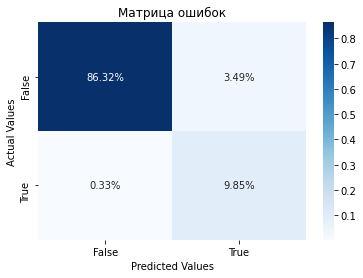

In [45]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Матрица ошибок')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True']) #подпишем значения
ax.yaxis.set_ticklabels(['False','True'])


plt.show() #визуализируем матрицу ошибок

## Общий вывод

Таким образом, были проделаны следующие работы:

    - в столбце 'text' слова приведены к нижнему регистру и к начальной форме, также очищены знаки препинания и прочие символы.
    - выделены признаки и разделены на обучающую и тестовую выборки.
    - выделены из корпуса уникальные слова и посчитано количество их вхождений в каждом тексте корпуса.
    - обучены различные модели.
    
Исходя из результатов, наилучший показатель f1 дает модель LogisticRegression 0.84.

Тестирование модели LogisticRegression на тестовой выборке прошло успешно (0.75).

Визуализировав матрицу ошибок, видно, что модель классифицировала комментарии на негативные и положительные (86.3% и 9.9%).

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны